In [46]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

# Make the VF Solution and use it as input to network

import sys
sys.path.insert(0,'..')
import VF.vectorfit

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# 1. Load the data and get measurements

In [48]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 5

In [49]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [50]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [51]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 1001)
GT S-parameters shape:  (10, 2, 1001)
Y S-parameters shape:  (10, 2, 10)


In [52]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (1001,)
Y frequencies shape:  (10,)


In [53]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  1000000.0
Mean frequency spacing:  19999000.0
STD frequency spacing:  0.0
Mode frequency spacing:  19999000.0
Number of samples with non-equal spacing:  1


In [54]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [55]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  1001
N_SPARAMS:  10


In [56]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 1001])


In [57]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 1001])


## Plot some stuff

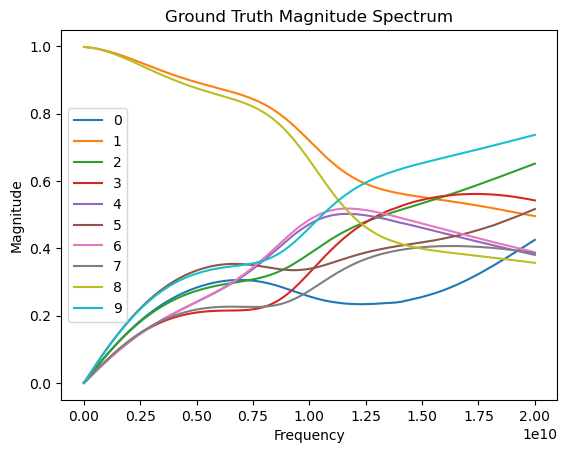

In [58]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

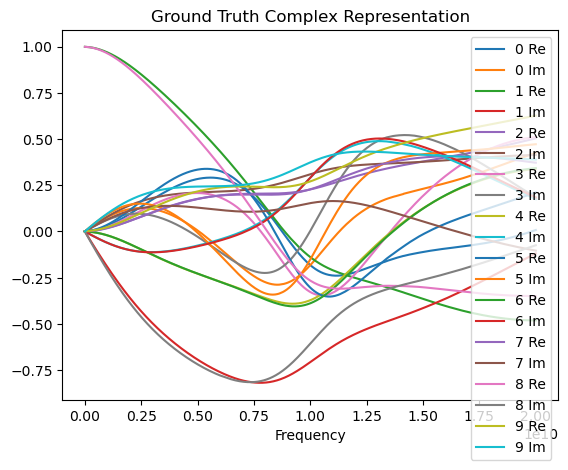

In [59]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [60]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 10

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)
old_kept = kept_inds.copy()

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

# remove every other point, starting at the back, don't remove first point
remove = False
for i in range(len(kept_inds) - 3, 2, -1):
    if remove:
        kept_inds = np.delete(kept_inds, [i])
        remove = False
    else:
        remove = True

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)
print(old_kept)

Number of Ground Truth Frequency Points:  1001
Number of Measurements:  10
Undersampling Ratio:  0.00999000999000999
[   0  111  222  333  555  777  888 1000]
[   0  111  222  333  444  555  666  777  888 1000]


In [61]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 8])
y_freqs shape:  (8,)


# 2. Network Setup

## Define network parameters

In [62]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [63]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  6
BASE NGF:  64
NGF:  [64, 64, 64, 64, 64, 64]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [64]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               )
net = net.to(device)

In [65]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 1001])


In [66]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  349384


# 3. Run

## Define training parameters, losses, and track stats

In [67]:
#grab the correct file we want for VF
NUM_ACTIVE = M - len(kept_inds)

LR = 2e-4
FIRST_ITER = 20000
NUM_ITER = 2000
CURR_ITER = FIRST_ITER
TOTAL_ITERS = FIRST_ITER + NUM_ITER * NUM_ACTIVE
NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

print("NUM ACTIVE: ", NUM_ACTIVE)

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        LENGTH_GT = len(gt_freqs)
        cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
        fname = os.path.join(ROOT_PATH, "case"+cn)

        children = os.listdir(fname)
        children = [f for f in children if cn + ".s" in f]

        final_path = os.path.join(fname, children[0])

        fitter = VF.vectorfit.VectorFitter(final_path)
        fit1 = fitter.vector_fit("VF Result", y_freqs) 
        vf_output = fit1.fitted_network.s

        vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
        vf_data = utils.matrix_to_sparams(vf_data)
        vf_data = torch.tensor(vf_data).view(1, -1, LENGTH_GT)
        vf_data = vf_data.to(device)

        
        # Find the maximum standard deviation point, and use it to update kept_inds
        print(sgld_outputs_by_sample)
        max_disagree_idx = find_max_variance(sgld_outputs_by_sample[-1][-1], vf_data, pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]


    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)


    for i in range(int(CURR_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (NUM_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        CURR_ITER = NUM_ITER
        is_initial_fit = False


    def find_max_variance(outputs, vf_outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        print(vf_outputs.shape)
        print(outputs.shape)
        sqr_differences = torch.square(torch.subtract(vf_outputs[0], outputs))

        # Sum to go to [1000]
        sqr_differences = torch.mean(sqr_differences, dim=0)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(sqr_differences) - 1)
                if rand_idx not in kept_inds:
                    print("picked: ", rand_idx)
                    return rand_idx

        _, idxs = torch.topk(sqr_differences, len(sqr_differences))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


NUM ACTIVE:  2
ITER  0
TIME:  0.021299362182617188
NOISE LEVEL:  0.9997122182804811

ITER  999
TIME:  22.777780055999756
NOISE LEVEL:  0.7498942093324799

ITER  1999
TIME:  47.42077374458313
NOISE LEVEL:  0.5623413251903846

ITER  2999
TIME:  71.57851362228394
NOISE LEVEL:  0.42169650342862214

ITER  3999
TIME:  94.4602963924408
NOISE LEVEL:  0.3162277660168785

ITER  4999
TIME:  116.72248435020447
NOISE LEVEL:  0.23713737056620426

ITER  5999
TIME:  138.4465754032135
NOISE LEVEL:  0.17782794100392685

ITER  6999
TIME:  159.9035964012146
NOISE LEVEL:  0.13335214321636304

ITER  7999
TIME:  182.43169164657593
NOISE LEVEL:  0.10000000000002636

ITER  8999
TIME:  204.47394323349
NOISE LEVEL:  0.07498942093326791

ITER  9999
TIME:  225.71393823623657
NOISE LEVEL:  0.05623413251905338

ITER  10999
TIME:  246.90012550354004
NOISE LEVEL:  0.04216965034287348

ITER  11999
TIME:  268.3359191417694
NOISE LEVEL:  0.03162277660169619

ITER  12999
TIME:  290.61286664009094
NOISE LEVEL:  0.023713737

/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: RuntimeWarning: Replacing d_res solution as it was too small. This is not a good sign and probably means that more starting poles are required
  vf.vector_fit(n_poles_cmplx=n_poles)
/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/skrf/vectorFitting.py:869: RuntimeWarning: invalid value encountered in sqrt
  for sqrt_eigenval in np.sqrt(P_eigs):
/u/bodeng/CurveFitting-DIP/vf_diff_sampling/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


ITER  999
TIME:  471.7789170742035
NOISE LEVEL:  0.002371373705663268

ITER  1999
TIME:  493.4011261463165
NOISE LEVEL:  0.0017782794100401876

NUM_SAMPLES  1
TIME:  493.4011261463165
Performing fit with 1 poles.
  Fitting took 0.008295612409710884 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.030501509085297585 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 3 (err 0.0003191567741914797 vs 0.005405131605588052)
Fit completed in 0.11921358108520508, using 2, resulting in a fit with 4 and error=0.0003191567741914797 vs samples and error=0.0006376720232924598 vs ground truth.
[tensor([[[ 3.6581e-02,  2.9152e-02,  1.4291e-02,  ..., -4.6243e-02,
          -5.0613e-02, -5.4345e-02],
         [-6.6217e-03, -1.9536e-02, -2.2864e-02,  ...,  3.4824e-02,
           3.3420e-02,  3.3752e-02],
         [ 7.9061e-01,  7.7599e-01,  7.4677e-01,  ..., 

In [68]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

print(sgld_outputs_by_sample[0].shape)
print(sgld_means_by_sample[0].shape)
print(sgld_stds_by_sample[0].shape)

torch.Size([455, 20, 1001])
torch.Size([20, 1001])
torch.Size([20, 1001])


## Plot metrics and outputs

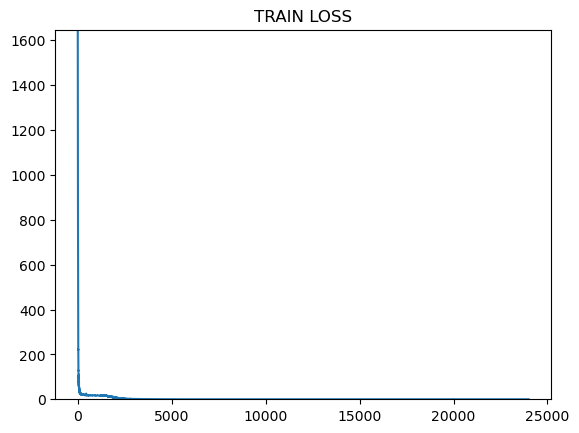

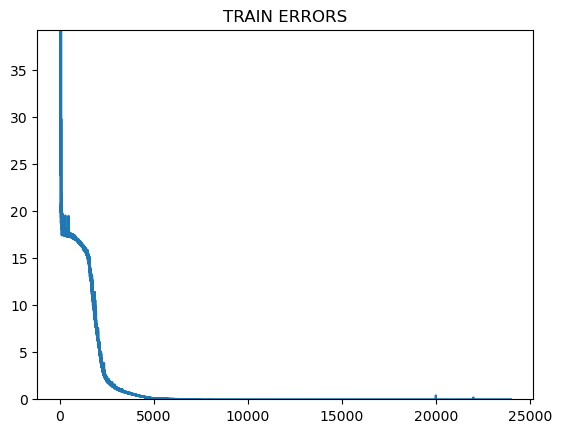

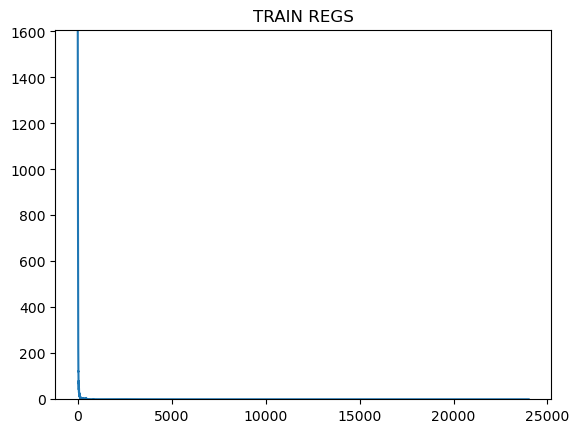

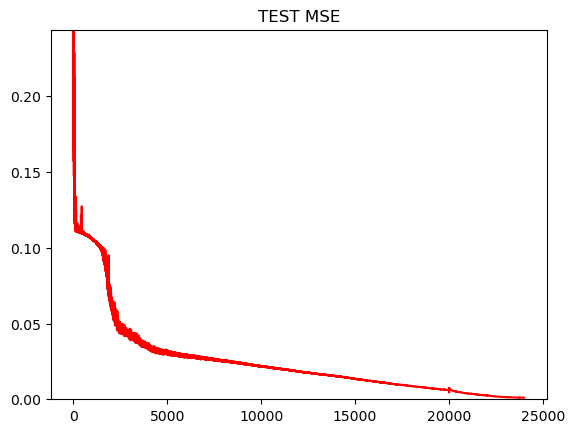

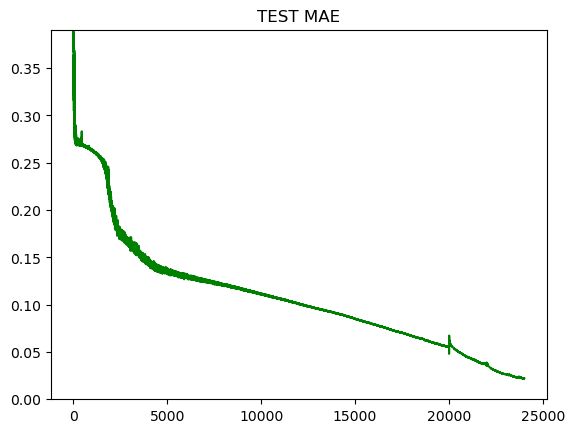

In [69]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [70]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.001048603910021484
Best Test MSE:  0.001007096841931343
Best Test MSE Iteration:  23993


In [71]:
LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case05/case05.s4p
[1.0000000e+06 2.2208890e+09 4.4407780e+09 6.6606670e+09 1.1100445e+10
 1.4200290e+10 1.5540223e+10 1.7760112e+10 1.9060047e+10 2.0000000e+10]
Performing fit with 1 poles.
  Fitting took 0.02174101211130619 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.042920395731925964 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 3 (err 0.0003125641951362171 vs 0.0053479177365605)
Fit completed in 0.23327374458312988, using 2, resulting in a fit with 4 and error=0.0003125641951362171 vs samples and error=0.0006326841708597374 vs ground truth.
(1001, 4, 4)
complex128
torch.Size([1, 20, 1001])


In [72]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
print("Mean DIP MSE: ", nn.MSELoss()(sgld_means_by_sample[-1][np.newaxis], x).item())

torch.Size([1001, 4, 4, 2])
torch.Size([1001, 4, 4, 2])
torch.Size([10, 4, 4, 2])
(1001, 4, 4, 2)
(1001, 4, 4, 2)
(10, 2, 1001)
(10, 2, 1001)
float32
float32
DIP PSNR:       35.81448528300764
VF PSNR:        52.90581343559147
Final DIP MSE:  0.001048603910021484
VF MSE:         2.0487013898673467e-05
Mean DIP MSE:  0.0010805404745042324


(1001,)
torch.Size([20, 1001])
torch.Size([1, 20, 1001])
torch.Size([1, 20, 10])
torch.Size([1, 20, 1001])
torch.Size([1, 20, 1001])


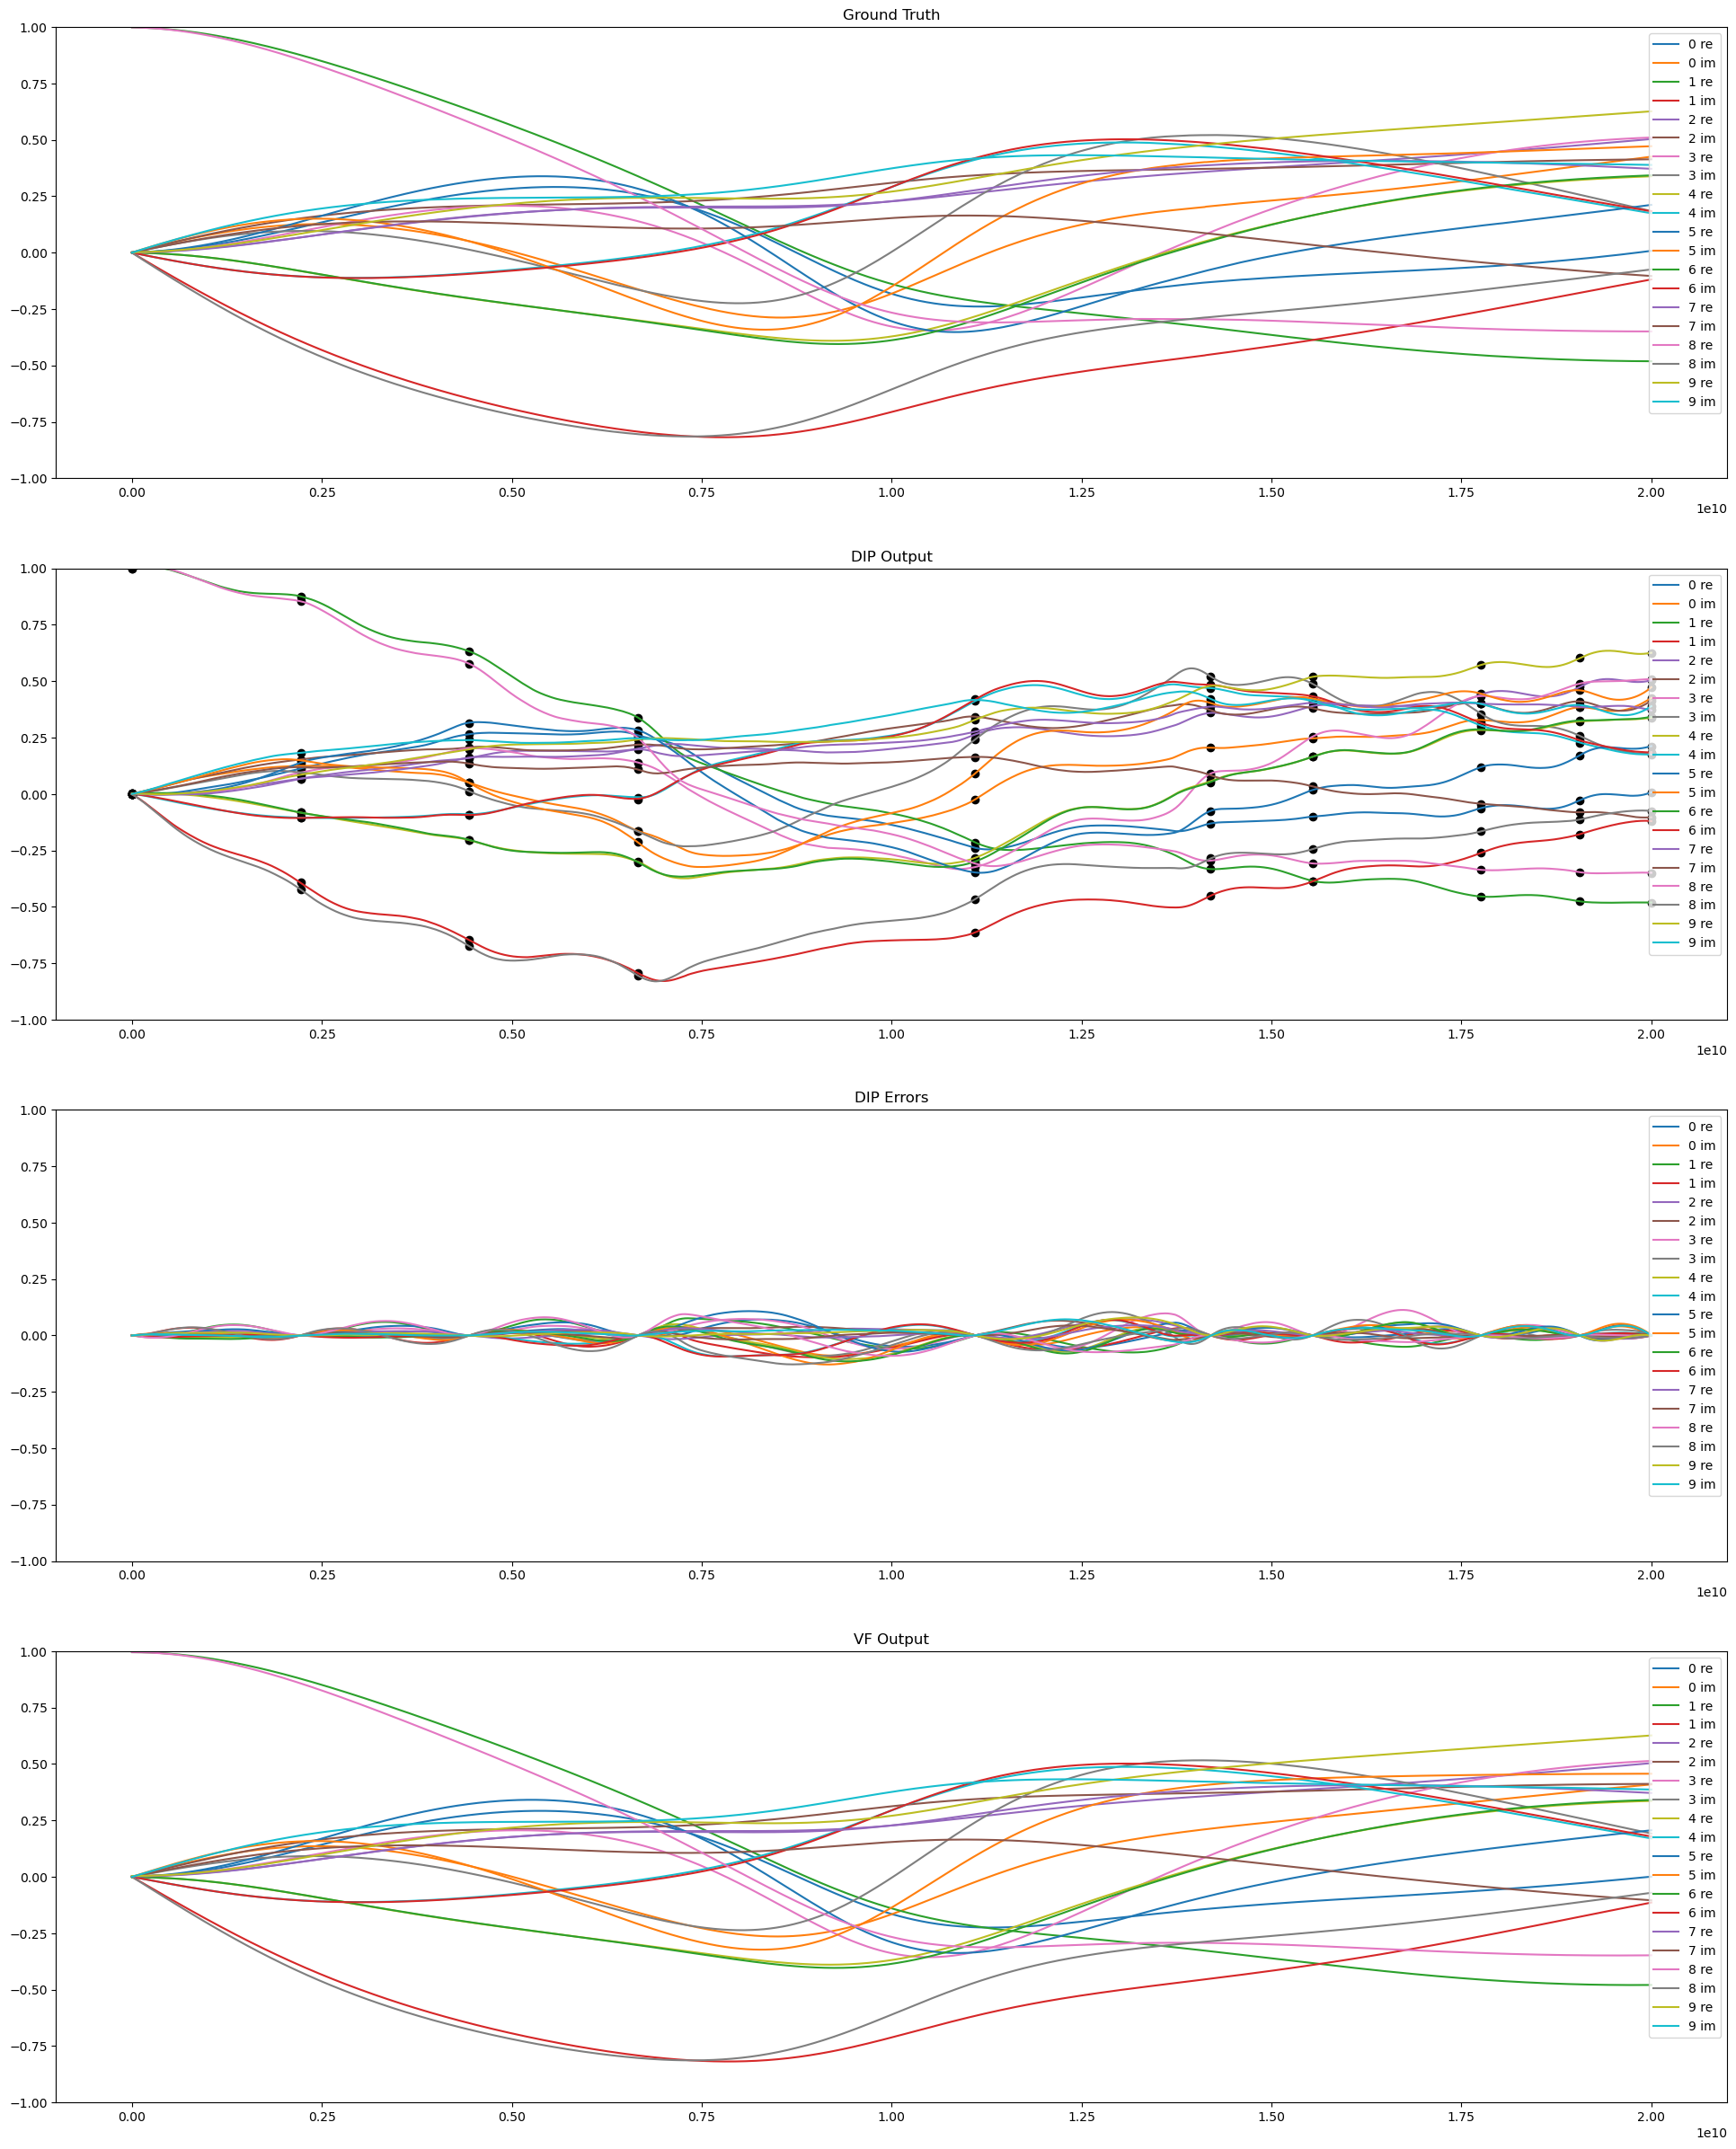

In [79]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')

axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [74]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[1.1729e-03, 1.1943e-03, 1.2382e-03, 1.2690e-03, 1.2864e-03, 1.3166e-03,
         1.3610e-03, 1.3891e-03, 1.4006e-03, 1.4003e-03, 1.3865e-03, 1.3818e-03,
         1.3861e-03, 1.3868e-03, 1.3833e-03, 1.3762e-03, 1.3794e-03, 1.3678e-03,
         1.3053e-03, 1.2105e-03, 1.0999e-03, 1.0042e-03, 9.2804e-04, 8.6832e-04,
         8.3141e-04, 8.2290e-04, 8.3554e-04, 8.5472e-04, 8.8862e-04, 9.4369e-04,
         1.0083e-03, 1.0829e-03, 1.1705e-03, 1.2433e-03, 1.2940e-03, 1.3189e-03,
         1.3188e-03, 1.3122e-03, 1.2984e-03, 1.2666e-03, 1.2230e-03, 1.1917e-03,
         1.1794e-03, 1.1793e-03, 1.1937e-03, 1.2313e-03, 1.2885e-03, 1.3354e-03,
         1.3639e-03, 1.3865e-03, 1.4010e-03, 1.3834e-03, 1.3312e-03, 1.2589e-03,
         1.1681e-03, 1.0783e-03, 9.9141e-04, 8.9855e-04, 8.0121e-04, 7.2073e-04,
         6.6157e-04, 6.2125e-04, 5.9566e-04, 5.8347e-04, 5.8983e-04, 6.0292e-04,
         6.1486e-04, 6.2445e-04, 6.2743e-04, 6.2414e-04, 6.1921e-04, 6.1730e-04,
         6.2119e-04, 6.3561e

In [75]:
print(dip_errors[-1])

tensor([[ 3.4004e-04,  5.1816e-04,  7.5501e-04,  9.7588e-04,  1.2262e-03,
          1.4749e-03,  1.7222e-03,  1.9858e-03,  2.2667e-03,  2.5447e-03,
          2.8200e-03,  3.0865e-03,  3.3460e-03,  3.5928e-03,  3.8267e-03,
          4.0813e-03,  4.3426e-03,  4.5990e-03,  4.7784e-03,  4.9266e-03,
          5.0649e-03,  5.2112e-03,  5.3675e-03,  5.5032e-03,  5.6207e-03,
          5.7082e-03,  5.7647e-03,  5.8014e-03,  5.8171e-03,  5.7696e-03,
          5.6580e-03,  5.5038e-03,  5.3072e-03,  5.0777e-03,  4.8161e-03,
          4.5304e-03,  4.2220e-03,  3.8961e-03,  3.5526e-03,  3.2000e-03,
          2.8373e-03,  2.4743e-03,  2.1102e-03,  1.7594e-03,  1.4222e-03,
          1.1214e-03,  8.5811e-04,  6.4789e-04,  4.9082e-04,  3.7631e-04,
          3.0395e-04,  3.1480e-04,  3.9992e-04,  5.4369e-04,  7.4439e-04,
          9.5167e-04,  1.1655e-03,  1.3894e-03,  1.6227e-03,  1.8822e-03,
          2.1686e-03,  2.4518e-03,  2.7320e-03,  2.9847e-03,  3.2106e-03,
          3.3970e-03,  3.5445e-03,  3.

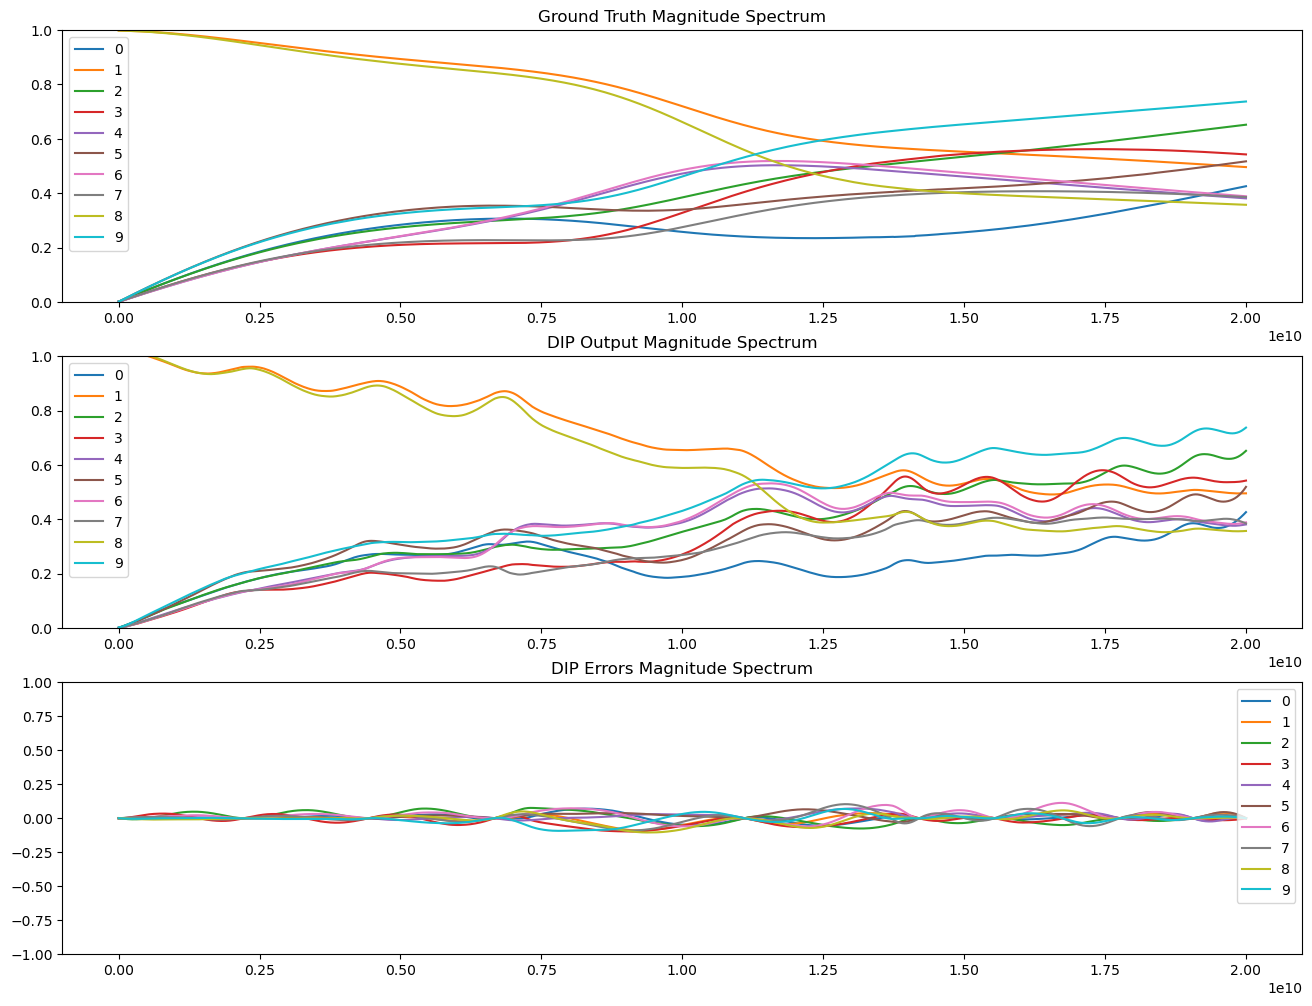

In [76]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [77]:
print(kept_inds)

[   0  111  222  333  555  710  777  888  953 1000]
